In [1]:
!wget --no-check-certificate \
    https://github.com/sakinahaulia153/UTS-AI/raw/main/Datasett.zip\
    -O /tmp/Dataset.zip

--2022-11-14 14:10:48--  https://github.com/sakinahaulia153/UTS-AI/raw/main/Datasett.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sakinahaulia153/UTS-AI/main/Datasett.zip [following]
--2022-11-14 14:10:48--  https://raw.githubusercontent.com/sakinahaulia153/UTS-AI/main/Datasett.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613689 (599K) [application/zip]
Saving to: ‘/tmp/Dataset.zip’

/tmp/Dataset.zip    100%[===================>] 599.31K  --.-KB/s    in 0.008s  

2022-11-14 14:10:48 (77.6 MB/s) - ‘/tmp/Dataset.zip’ saved [613689/613689]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Extract file zip dataset

import os
import zipfile

local_zip = '/tmp/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [14]:
base_dir = '/tmp/Datasett'
Train_dir = os.path.join(base_dir, 'Train')
Val_dir = os.path.join(base_dir, 'Test')


In [15]:
Pepaya_Train_path = Train_dir + '/Pepaya'
Seledri_Train_path = Train_dir + '/Seledri'
Pepaya_val_path = Val_dir + '/Pepaya'
Seledri_val_path = Val_dir + '/Seledri'


Pepaya_len_Train = len(os.listdir(Pepaya_Train_path))
Seledri_len_Train = len(os.listdir(Seledri_Train_path))
Pepaya_len_val = len(os.listdir(Pepaya_val_path))
Seledri_len_val = len(os.listdir(Seledri_val_path))

print("Jumlah dataset Training : ", Pepaya_len_Train + Seledri_len_Train)
print("Jumlah dataset validasi : ", Pepaya_len_val + Seledri_len_val)
print("\n\n")
print("Jumlah train kelas Pepaya : ", Pepaya_len_Train)
print("Jumlah train kelas Seledri : ", Seledri_len_Train)
print("Jumlah validasi kelas Pepaya : ", Pepaya_len_val)
print("Jumlah validasi kelas Seledri : ", Seledri_len_val)

Jumlah dataset Training :  80
Jumlah dataset validasi :  20



Jumlah train kelas Pepaya :  40
Jumlah train kelas Seledri :  40
Jumlah validasi kelas Pepaya :  10
Jumlah validasi kelas Seledri :  10


In [16]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        Train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        Val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [61]:
# set the matplotlib backend so figures can be saved in the background
!pip install --upgrade imutils

import matplotlib
matplotlib.use("Agg")
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
#from google.colab.patches import cv2_imshow
from imutils import build_montages
#from google.colab import files
import numpy as np
import argparse
import pickle
import shutil
import os
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
'''
definisikan dan setting callback untuk :
1. memantau performa model
2. melakukan save model terbaik menggunakan model checkpoint
3. memberhentikan pelatihan ketika tidak memnuhi syarat dalam parameter earlystopping
'''

callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/Colab Notebooks/TugasBesar/model_drop_batch_weight_from_callback_2.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [41]:
'''
definisikan pretrained model yang ingin digunakan
'''

VGG16_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', #include_top = false , berarti fully connected layer akan dipidah dari arsitektur
                                                 input_tensor=None, input_shape=(224, 224,3))

In [42]:
'''
melakukan setting bahwa model pretrained tidak akan dilatih ulang
'''

VGG16_base.trainable = False

In [43]:
'''
mendefinisikan layer pada bagian fully connected layer
'''

print('Adding new layers')
output = VGG16_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output) 
print('New layers Finishing Added!!!!')

Adding new layers
New layers Finishing Added!!!!


In [44]:
VGG16_model = Model(VGG16_base.input, output)

VGG16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [45]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

In [63]:
history = VGG16_model.fit(
      train_generator,
      steps_per_epoch=4,  # images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=2,  #  images = batch_size * steps
      callbacks = [callbacks, best_model])

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 1.0000

4/4 [==============================] - 38s 9s/step - loss: 0.0526 - accuracy: 1.0000
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9250

4/4 [==============================] - 39s 10s/step - loss: 0.1146 - accuracy: 0.9250
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9750

4/4 [==============================] - 39s 10s/step - loss: 0.0797 - accuracy: 0.9750
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9625 

4/4 [==============================] - 40s 10s/step - loss: 0.0689 - accuracy: 0.9625
Epoch 5/50
4/4 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9625

4/4 [==============================] - 38s 9s/step - loss: 0.1260 - accuracy: 0.9625
Epoch 6/50
4/4 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9875

4/4 [==============================] - 38s 9s/step - loss: 0.0726 - accuracy: 0.9875
Epoch 7/50
4/4 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9875

4/4 [==============================] - 38s 9s/step - loss: 0.0368 - accuracy: 0.9875
Epoch 8/50
4/4 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9750

4/4 [==============================] - 38s 9s/step - loss: 0.0524 - accuracy: 0.9750
Epoch 9/50
4/4 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9625

4/4 [==============================] - 38s 9s/step - loss: 0.1301 - accuracy: 0.9625
Epoch 10/50
4/4 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9375

4/4 [==============================] - 41s 10s/step - loss: 0.1333 - accuracy: 0.9375
Epoch 11/50
4/4 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9875

4/4 [==============================] - 38s 9s/step - loss: 0.0438 - accuracy: 0.9875
Epoch 12/50
4/4 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9625

4/4 [==============================] - 38s 9s/step - loss: 0.0940 - accuracy: 0.9625
Epoch 13/50
4/4 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 1.0000

4/4 [==============================] - 43s 9s/step - loss: 0.0424 - accuracy: 1.0000
Epoch 14/50
4/4 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9500

4/4 [==============================] - 38s 10s/step - loss: 0.0734 - accuracy: 0.9500
Epoch 15/50
4/4 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9750

4/4 [==============================] - 40s 10s/step - loss: 0.0550 - accuracy: 0.9750
Epoch 16/50
4/4 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9875

4/4 [==============================] - 38s 9s/step - loss: 0.0508 - accuracy: 0.9875
Epoch 17/50
4/4 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9875

4/4 [==============================] - 37s 9s/step - loss: 0.0489 - accuracy: 0.9875
Epoch 18/50
4/4 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9750

4/4 [==============================] - 37s 9s/step - loss: 0.0604 - accuracy: 0.9750
Epoch 19/50
4/4 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 1.0000

4/4 [==============================] - 37s 9s/step - loss: 0.0277 - accuracy: 1.0000
Epoch 20/50
4/4 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9875

4/4 [==============================] - 37s 9s/step - loss: 0.0555 - accuracy: 0.9875
Epoch 21/50
4/4 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 1.0000

4/4 [==============================] - 37s 9s/step - loss: 0.0489 - accuracy: 1.0000
Epoch 22/50
4/4 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9500 

4/4 [==============================] - 44s 11s/step - loss: 0.1111 - accuracy: 0.9500
Epoch 23/50
4/4 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9500

4/4 [==============================] - 38s 9s/step - loss: 0.0680 - accuracy: 0.9500
Epoch 24/50
4/4 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9750

4/4 [==============================] - 39s 9s/step - loss: 0.0673 - accuracy: 0.9750
Epoch 25/50
4/4 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9750

4/4 [==============================] - 38s 9s/step - loss: 0.0513 - accuracy: 0.9750
Epoch 26/50
4/4 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 1.0000

4/4 [==============================] - 37s 9s/step - loss: 0.0305 - accuracy: 1.0000
Epoch 27/50
4/4 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9750

4/4 [==============================] - 38s 9s/step - loss: 0.0637 - accuracy: 0.9750
Epoch 28/50
4/4 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9750

4/4 [==============================] - 38s 9s/step - loss: 0.0870 - accuracy: 0.9750
Epoch 29/50
4/4 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9750

4/4 [==============================] - 37s 9s/step - loss: 0.0758 - accuracy: 0.9750
Epoch 30/50
4/4 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9875

4/4 [==============================] - 37s 9s/step - loss: 0.0711 - accuracy: 0.9875
Epoch 31/50
4/4 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9750

4/4 [==============================] - 37s 9s/step - loss: 0.0505 - accuracy: 0.9750
Epoch 32/50
4/4 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9875

4/4 [==============================] - 37s 9s/step - loss: 0.0402 - accuracy: 0.9875
Epoch 33/50
4/4 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9750

4/4 [==============================] - 37s 9s/step - loss: 0.0860 - accuracy: 0.9750
Epoch 34/50
4/4 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9750

4/4 [==============================] - 37s 9s/step - loss: 0.0706 - accuracy: 0.9750
Epoch 35/50
4/4 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9875

4/4 [==============================] - 37s 9s/step - loss: 0.0297 - accuracy: 0.9875
Epoch 36/50
4/4 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 1.0000

4/4 [==============================] - 37s 9s/step - loss: 0.0216 - accuracy: 1.0000
Epoch 37/50
4/4 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 1.0000

4/4 [==============================] - 38s 9s/step - loss: 0.0258 - accuracy: 1.0000
Epoch 38/50
4/4 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9875

4/4 [==============================] - 37s 9s/step - loss: 0.0424 - accuracy: 0.9875
Epoch 39/50
4/4 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9750

4/4 [==============================] - 37s 9s/step - loss: 0.0639 - accuracy: 0.9750
Epoch 40/50
4/4 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 1.0000

4/4 [==============================] - 37s 9s/step - loss: 0.0217 - accuracy: 1.0000
Epoch 41/50
4/4 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9500

4/4 [==============================] - 38s 9s/step - loss: 0.1800 - accuracy: 0.9500
Epoch 42/50
4/4 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9750

4/4 [==============================] - 37s 9s/step - loss: 0.0942 - accuracy: 0.9750
Epoch 43/50
4/4 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.9500

4/4 [==============================] - 37s 9s/step - loss: 0.1131 - accuracy: 0.9500
Epoch 44/50
4/4 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000

4/4 [==============================] - 37s 9s/step - loss: 0.0155 - accuracy: 1.0000
Epoch 45/50
4/4 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 1.0000

4/4 [==============================] - 37s 9s/step - loss: 0.0264 - accuracy: 1.0000
Epoch 46/50
4/4 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000

4/4 [==============================] - 37s 9s/step - loss: 0.0120 - accuracy: 1.0000
Epoch 47/50
4/4 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9625

4/4 [==============================] - 37s 9s/step - loss: 0.0889 - accuracy: 0.9625
Epoch 48/50
4/4 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9875

4/4 [==============================] - 37s 9s/step - loss: 0.0690 - accuracy: 0.9875
Epoch 49/50
4/4 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9875

4/4 [==============================] - 38s 9s/step - loss: 0.0437 - accuracy: 0.9875
Epoch 50/50
4/4 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9750

4/4 [==============================] - 37s 9s/step - loss: 0.0738 - accuracy: 0.9750


In [71]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

KeyError: ignored

In [66]:
# import some of library that we need to look the confusion matrix, recall, f1_score, and accuracy score to look how much your model is well
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [67]:
# loading model to evaluate more depth
from keras.models import load_model
model_path =  '/content/gdrive/MyDrive/Colab Notebooks/TugasBesar/model_drop_batch_weight_from_callback_2.h5'
model = load_model(model_path)

Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Accuracy  : 0.9
Precision : 0.9166666666666667
f1Score : 0.898989898989899
[[ 8  2]
 [ 0 10]]


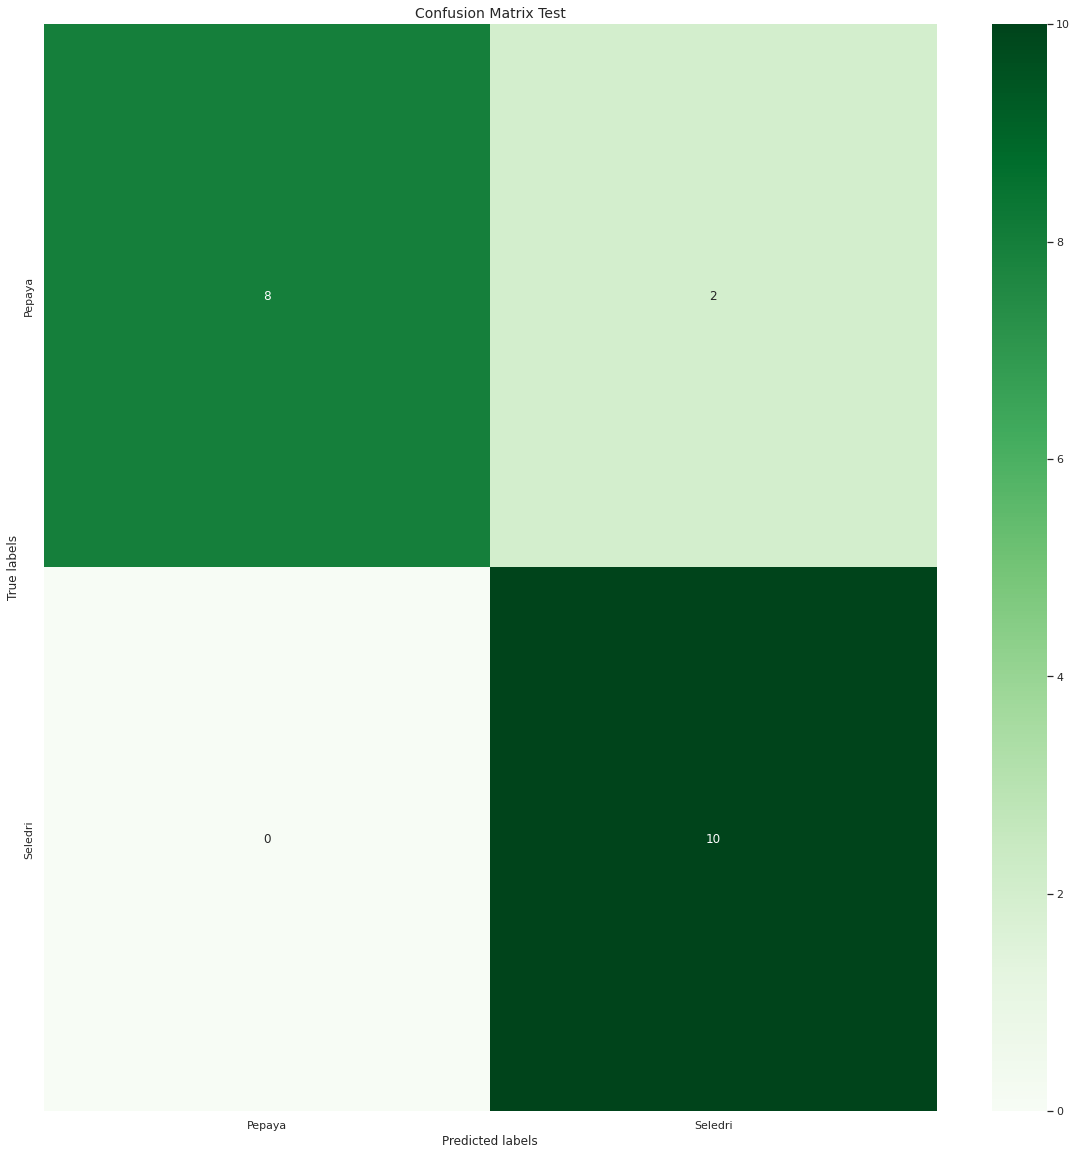

In [68]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=224; width=224
batch_size=20

test_datagen = ImageDataGenerator(rescale=1./255)

TESTING_DIR = Val_dir

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(20,20))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Greens)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [69]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, yPredictions, target_names=class_names))

              precision    recall  f1-score   support

      Pepaya       1.00      0.80      0.89        10
     Seledri       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

